In [1]:


import pandas as pd

In [2]:
import os
import rasterio
import numpy as np

# Set the directory path containing the .tif files (X_train, y_train, X_test)
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp', '../data/raw/test_satellite']

# Get a list of all files in the directory (X_train, y_train, X_test)
file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

# Sort the file list to ensure consistent order
file_list = [sorted(files) for files in file_list]

# Initialize an empty array to store the image data
X_train, y_train, X_test = [], [], []

# Iterate through the selected files
for X_train_name, y_train_name in zip(file_list[0], file_list[1]):
    # Construct the full path to the file
    X_train_path = os.path.join(directory_paths[0], X_train_name)
    y_train_path = os.path.join(directory_paths[1], y_train_name)

    # Open the raster file using rasterio
    with rasterio.open(X_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_train.append(image_data)

    # Open the raster file using rasterio
    with rasterio.open(y_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        y_train.append(image_data)

for X_test_name in file_list[2]:
    # Construct the full path to the file
    X_test_path = os.path.join(directory_paths[2], X_test_name)

    with rasterio.open(X_test_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_test.append(image_data)

# Convert the list of arrays to a single NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Print the shape of the resulting array
print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)
print("Shape of the X_test array:", X_test.shape)



C:\Users\hjdeh\Documents\GitHub\Q2\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5635, 7, 350, 350)
Shape of the y_train array: (5635, 1, 350, 350)
Shape of the X_test array: (1426, 7, 350, 350)


In [3]:
bands = ["SWIR", "NIR", "Red", "Green", "Blue", "Cloud Mask", "Digital Elevation Map"]

metadata = pd.read_csv('../data/raw/metadata_fTq0l2T.csv')
metadata = metadata.sort_values(by=['in_train', 'filename'], ascending=[False, True])

print(len(metadata))
metadata.head()

# Check for duplicate tile ids
print("Number of unique tile ids:", len(metadata['tile_id'].unique()))
print("Number of unique tile filenames:", len(metadata['filename'].unique()))

12696
Number of unique tile ids: 7061
Number of unique tile filenames: 12696


In [173]:
metadata.head(10)

tile_id                filename                          md5_hash  \
994   AA498489  AA498489_satellite.tif  59b984f8f7fe343884efed7cfb26d64a   
1873  AA648736  AA648736_satellite.tif  d3c0dc6609867db1157e6190205a1aee   
3899  AA800151  AA800151_satellite.tif  065c3410af64673f2ceed134215d13e3   
650   AA878727  AA878727_satellite.tif  3afb5204237cf4f9fcdf3f9fa33d15c9   
5005  AB160377  AB160377_satellite.tif  581f2bc5ea545409a1f202eeb9e233f5   
4226  AB417661  AB417661_satellite.tif  39e8c9c73c5504db1e91166614f7330f   
3255  AB440131  AB440131_satellite.tif  7e6c0a4195fa9a2a21b51ef476d364b4   
3310  AB602248  AB602248_satellite.tif  9eef4ea66ced8c3be820431700e989d7   
3705  AB678991  AB678991_satellite.tif  ff8ed30ed812171e5c33618b41c7ca87   
1865  AB795781  AB795781_satellite.tif  84d957cd6c55a5f8f9319b30dfc8a5e2   

      filesize_bytes       type  in_train  
994          1059490  satellite      True  
1873         1186857  satellite      True  
3899         1391679  satellite      True  
650          1216266  satellite      True  
5005         1626251  satellite      True  
4226          968280  satellite      True  
3255          982139  satellite      True  
3310         1394746  satellite      True  
3705         1470847  satellite      True  
1865         1125349  satellite      True

In [4]:
import cv2
from matplotlib import pyplot as plt
from rasterio.plot import show
from matplotlib.colors import ListedColormap


def normalize_images(images_array: np.ndarray):
    # Create an empty array to store the normalized image data
    normalized_images_array = np.zeros(images_array.shape)

    # Iterate through each band
    for i in range(images_array.shape[1]):
        # Get the band data
        band = images_array[:, i, :, :]
        # Set NaNs to 0 (Nan = -32768 in the original images)
        # For band 0 to 4, normalize the band data to values between 0 and 1 by dividing by 65535
        if i < 5:
            band[band == -32768] = 0
            normalized_band = band / 65535.0
            #normalized_band = cv2.normalize(normalized_band, None, 0, 1, cv2.NORM_MINMAX)

        # For band 5 do nothing
        elif i == 5:
            normalized_band = band
        # For band 6, do normal normalization
        elif i == 6:
            band[band == -32768] = 0
            #normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))

        # Store the normalized band data
        normalized_images_array[:, i, :, :] = normalized_band

    return normalized_images_array


def normalize_image(image: np.ndarray):
    normalized_images_array = np.zeros(image.shape)
    # Iterate through each band
    for i in range(image.shape[0]):
        # Get the band data
        band = image[i, :, :]
        # Set NaNs to 0 (Nan = -32768 in the original images)
        # For band 0 to 4, normalize the band data to values between 0 and 1 by dividing by 65535
        if i < 5:
            band[band == -32768] = 0
            normalized_band = band / 65535.0
        # For band 5 do nothing
        elif i == 5:
            normalized_band = band
        # For band 6, do normal normalization
        elif i == 6:
            band[band == -32768] = 0
            normalized_band = band
            #normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))

        # Store the normalized band data
        normalized_images_array[i, :, :] = normalized_band

    return normalized_images_array


def visualize_images(filenames: list, is_train=True):
    # Create a 2x3 grid for image display
    num_rows = len(filenames)
    num_cols = 5

    if is_train:
        X_normed = normalize_images(X_train[filenames, :, :, :])
    else:
        X_normed = normalize_images(X_test[filenames, :, :, :])
    # Normalize the images

    # Create a figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(80, num_rows * 20))

    # Flatten the 2D array of subplots into a 1D array
    axes = axes.flatten()
    c = 0
    cmap_mask = ListedColormap(['black', 'white'])
    # Display each image in a subplot
    for i in range(0, num_rows * num_cols, 5):
        # Display the RGB image
        show(X_normed[c, 2:5, :, :], ax=axes[i])
        axes[i].set_title("RGB Image")

        # Display the SWIR, NIR, Red image
        show(X_normed[c, 0:3, :, :], ax=axes[i + 1])
        axes[i + 1].set_title(f"SWIR, NIR, Red Image and file: {file_list[0][filenames[c]]}")

        # Display the Cloud mask band (5)

        axes[i + 2].imshow(X_normed[c, 5, :, :], cmap=cmap_mask)
        axes[i + 2].set_title("Cloud Mask")

        # Display the Digital Elevation Map band (6)
        show(X_normed[c, 6, :, :], ax=axes[i + 3])
        axes[i + 3].set_title("Digital Elevation Map")

        # Display the label
        show(X_normed[c, 0:3, :, :], ax=axes[i + 4])
        if is_train:
            axes[i + 4].imshow(y_train[filenames[c]][0], cmap='jet', alpha=0.5 * (y_train[filenames[c]][0] > 0))
        axes[i + 4].set_title("Label")
        # Display the SWIR, NIR, Red image with the label
        c += 1

    # Adjust layout for better spacing
    plt.tight_layout()
    if is_train:
        plt.savefig(f'../plots/images/train/visualize_images{str(filenames)}.png')
    else:
        plt.savefig(f'../plots/images/test/visualize_images{str(filenames)}.png')
    plt.show()


In [7]:
visualize_images([4, 5, 6, 7])

## NaN analysis

In [6]:
# Count the number of -32768 values for each band. These are NaNs, calculate the percentage of NaNs for each band
print("Train")
nan_count = np.sum(X_train == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_train.shape[0] * X_train.shape[2] * X_train.shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")

print("\nTest")
nan_count = np.sum(X_test == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_test.shape[0] * X_test.shape[2] * X_test.shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")

Train
Band SWIR                     : NaN Count = 28213403, NaN Percentage = 4.09%
Band NIR                      : NaN Count = 28216871, NaN Percentage = 4.09%
Band Red                      : NaN Count = 28254528, NaN Percentage = 4.09%
Band Green                    : NaN Count = 28252553, NaN Percentage = 4.09%
Band Blue                     : NaN Count = 28537626, NaN Percentage = 4.13%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.00%
Band Digital Elevation Map    : NaN Count = 26868442, NaN Percentage = 3.89%

Test
Band SWIR                     : NaN Count = 6981719, NaN Percentage = 4.00%
Band NIR                      : NaN Count = 6982737, NaN Percentage = 4.00%
Band Red                      : NaN Count = 6990982, NaN Percentage = 4.00%
Band Green                    : NaN Count = 6988761, NaN Percentage = 4.00%
Band Blue                     : NaN Count = 7045466, NaN Percentage = 4.03%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.

## NaN - Get the images that have the highest percentage of NaNs

In [7]:
# Get the indices of the images with the highest percentage of NaNs

print("Train")
nan_count = np.sum(X_train == -32768, axis=(1, 2, 3))

nan_percentage = nan_count / (X_train.shape[1] * X_train.shape[2] * X_train.shape[3]) * 100

#Sort the indices by the percentage of NaNs
sorted_indices_train = np.argsort(nan_percentage)

# Print the top 5 images with the highest percentage of NaNs
for i in range(5):
    print(
        f"Image {sorted_indices_train[-i - 1]:<5}: NaN Count = {nan_count[sorted_indices_train[-i - 1]]:<6}, NaN Percentage = {nan_percentage[sorted_indices_train[-i - 1]]:.2f}%")

print("\nTest")
nan_count = np.sum(X_test == -32768, axis=(1, 2, 3))

nan_percentage = nan_count / (X_test.shape[1] * X_test.shape[2] * X_test.shape[3]) * 100

#Sort the indices by the percentage of NaNs decendingly
sorted_indices_test = np.argsort(nan_percentage)

# Print the top 5 images with the highest percentage of NaNs
for i in range(5):
    print(
        f"Image {sorted_indices_test[-i - 1]:<5}: NaN Count = {nan_count[sorted_indices_test[-i - 1]]:<6}, NaN Percentage = {nan_percentage[sorted_indices_test[-i - 1]]:.2f}%")




Train
Image 4482 : NaN Count = 604870, NaN Percentage = 70.54%
Image 5288 : NaN Count = 593862, NaN Percentage = 69.26%
Image 719  : NaN Count = 565060, NaN Percentage = 65.90%
Image 4487 : NaN Count = 523210, NaN Percentage = 61.02%
Image 3339 : NaN Count = 519636, NaN Percentage = 60.60%

Test
Image 906  : NaN Count = 622920, NaN Percentage = 72.64%
Image 414  : NaN Count = 571490, NaN Percentage = 66.65%
Image 1336 : NaN Count = 556525, NaN Percentage = 64.90%
Image 704  : NaN Count = 544270, NaN Percentage = 63.47%
Image 670  : NaN Count = 542495, NaN Percentage = 63.26%


In [ ]:
# Put the image with the nan COunt and percentage in a dataframe
df_nan_count = pd.DataFrame(
    {'Image': sorted_indices_train[::-1], 'NaN Count': nan_count[sorted_indices_train[::-1]], 'NaN Percentage': nan_percentage[sorted_indices_train[::-1]]})

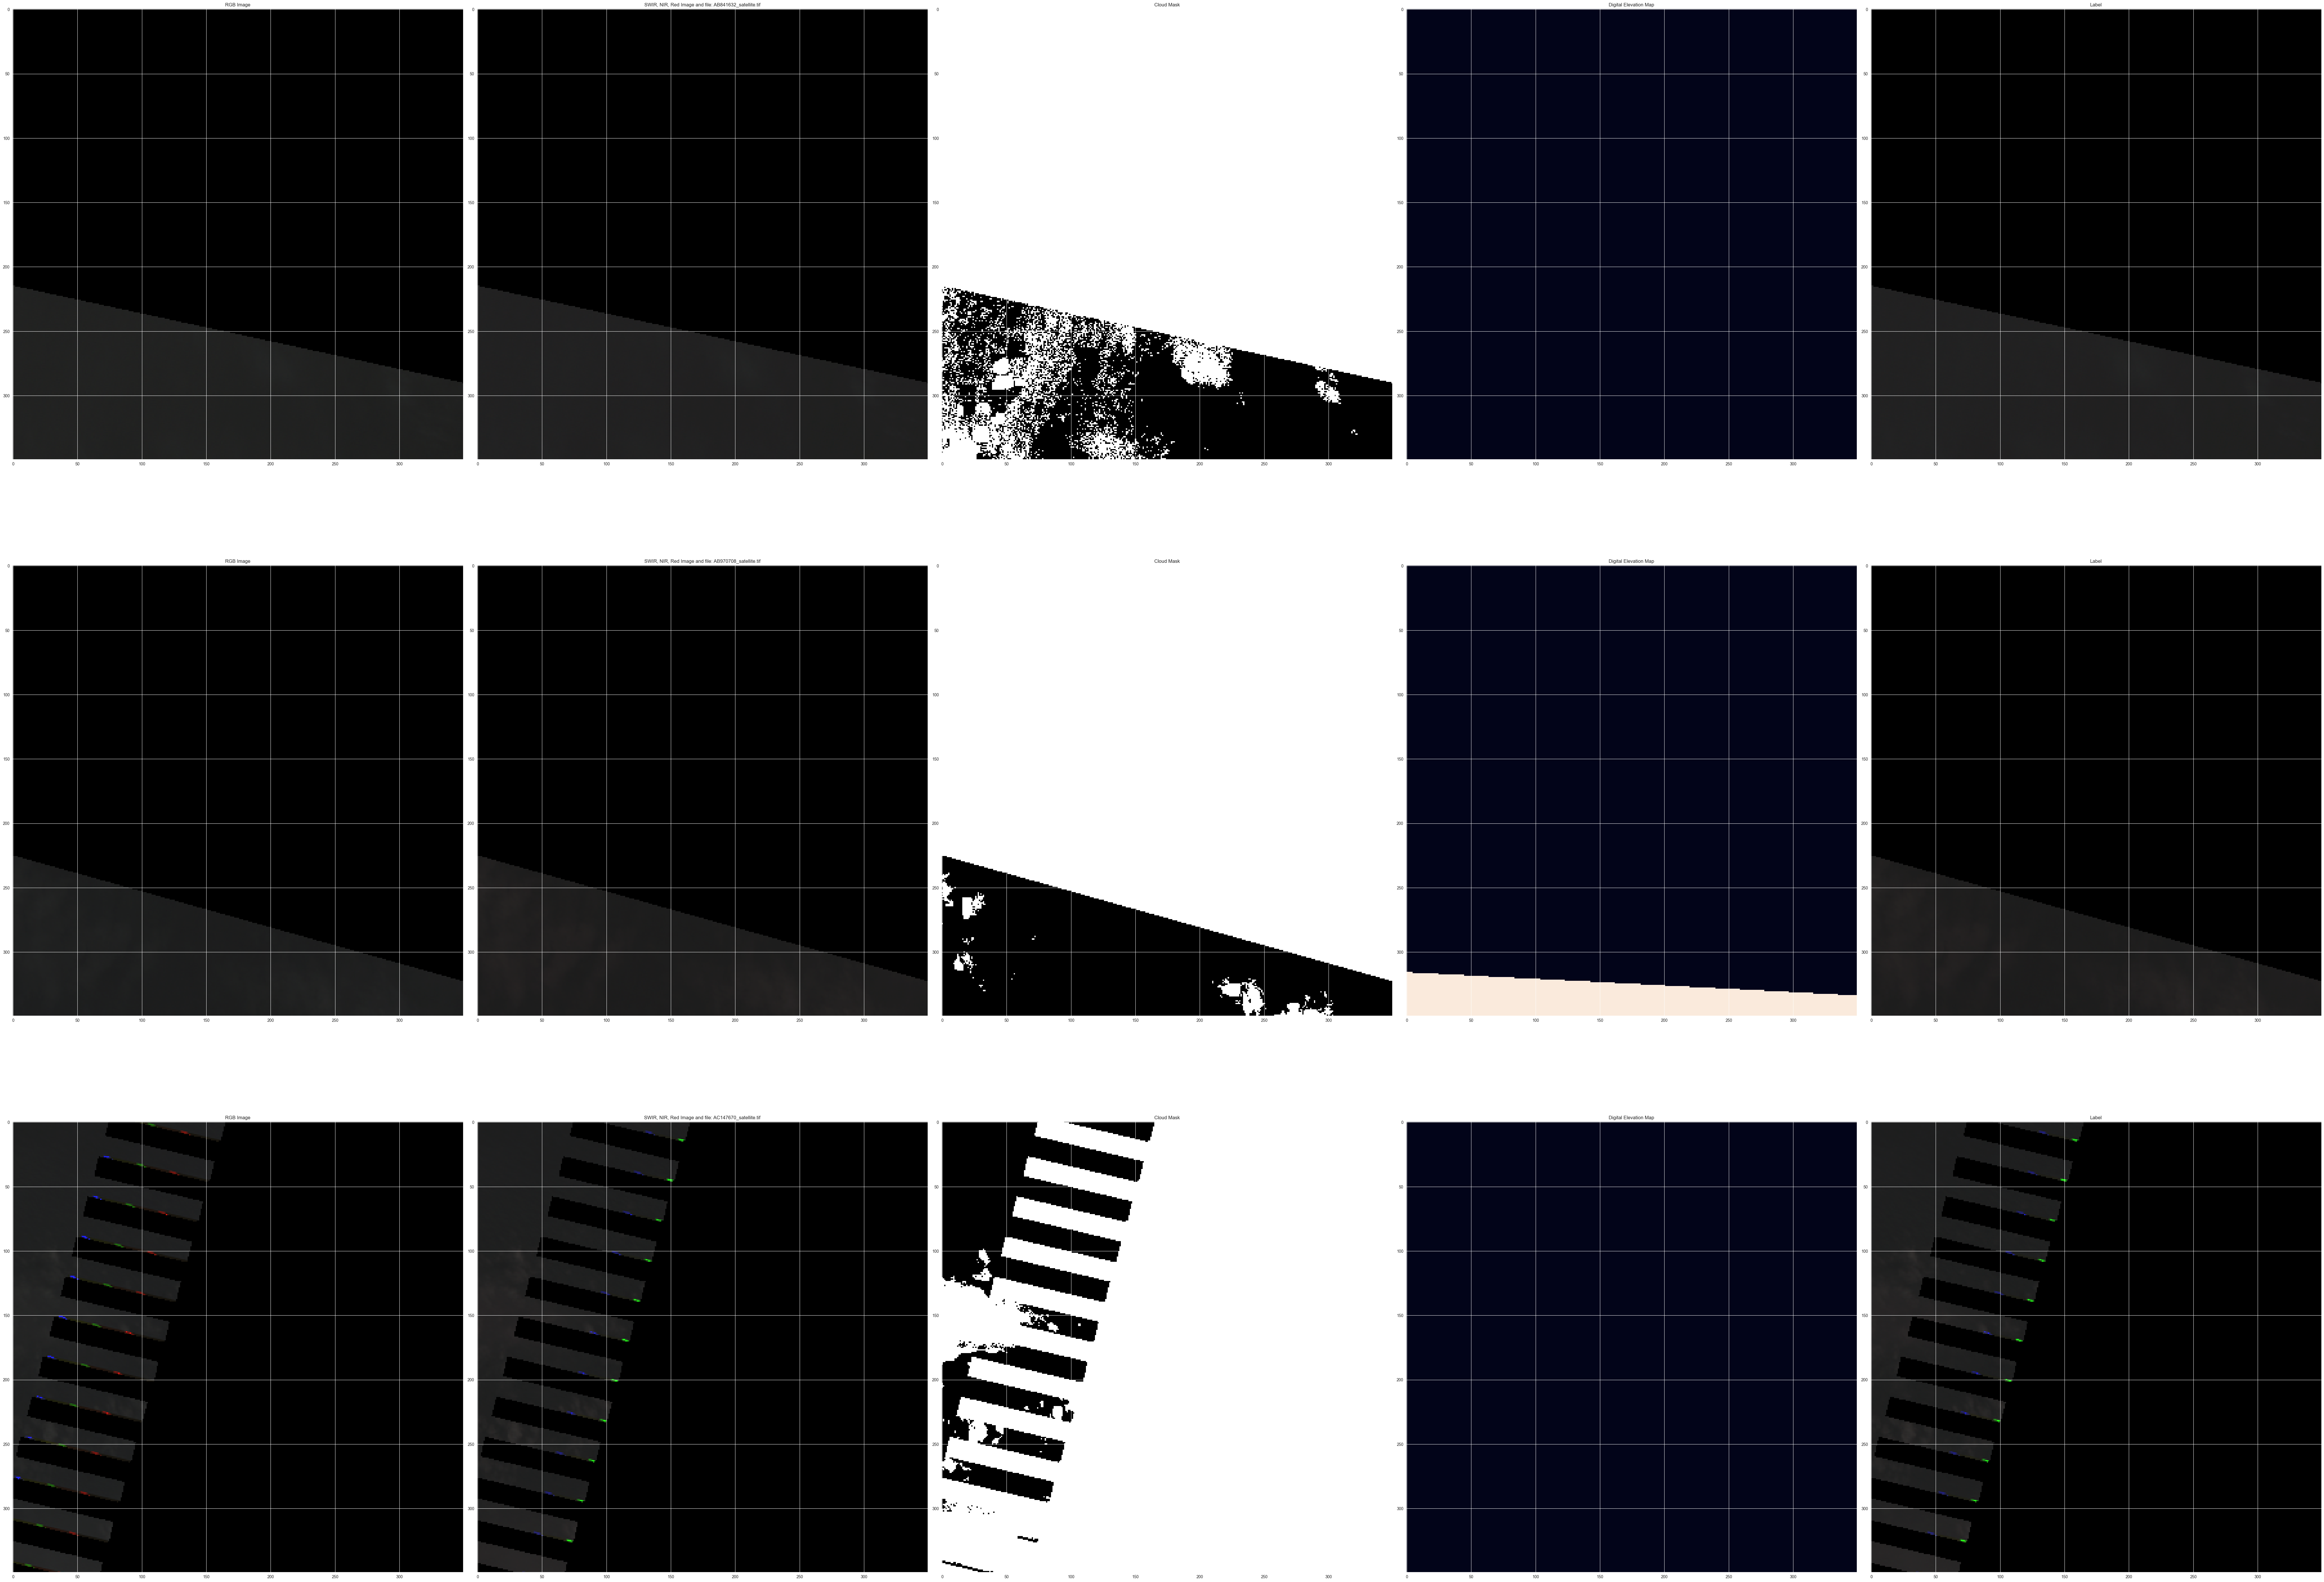

In [8]:
visualize_images(sorted_indices_train[-3:])

In [9]:
visualize_images(sorted_indices_test[-5:], is_train=False)

### Is there kelp in the images with the highest percentage of NaNs?

This is very interesting, lets analyse this by making a kdeplot over all bands to show the distribution of the bands values depending if there is kelp or no kelp


 Lets now try to get all values but apply a subsample and use that in the KDE Plot. THis is the correct way.

In [46]:
bands_kelp_subsample = []
bands_no_kelp_subsample = []

#Plot using seaborn:
for band in range(7):
    print(band)
    # For each band, get the values of the band where kelp is present and where kelp is not present

    # Get the indices where kelp is present
    y_kelp = np.where(y_train.ravel() != 0)
    X_kelp = X_train[:, band, :, :].ravel()[y_kelp]

    # Get the indices where kelp is not present
    y_no_kelp = np.where(y_train.ravel() == 0)
    X_no_kelp = X_train[:, band, :, :].ravel()[y_no_kelp]

    # Subsample 20000 values from kelp
    kelp = np.random.choice(X_kelp, 1000000)

    # Subsample 20000 values from no kelp
    no_kelp = np.random.choice(X_no_kelp, 1000000)

    bands_kelp_subsample.append(kelp)
    bands_no_kelp_subsample.append(no_kelp)


0
1
2
3
4
5
6


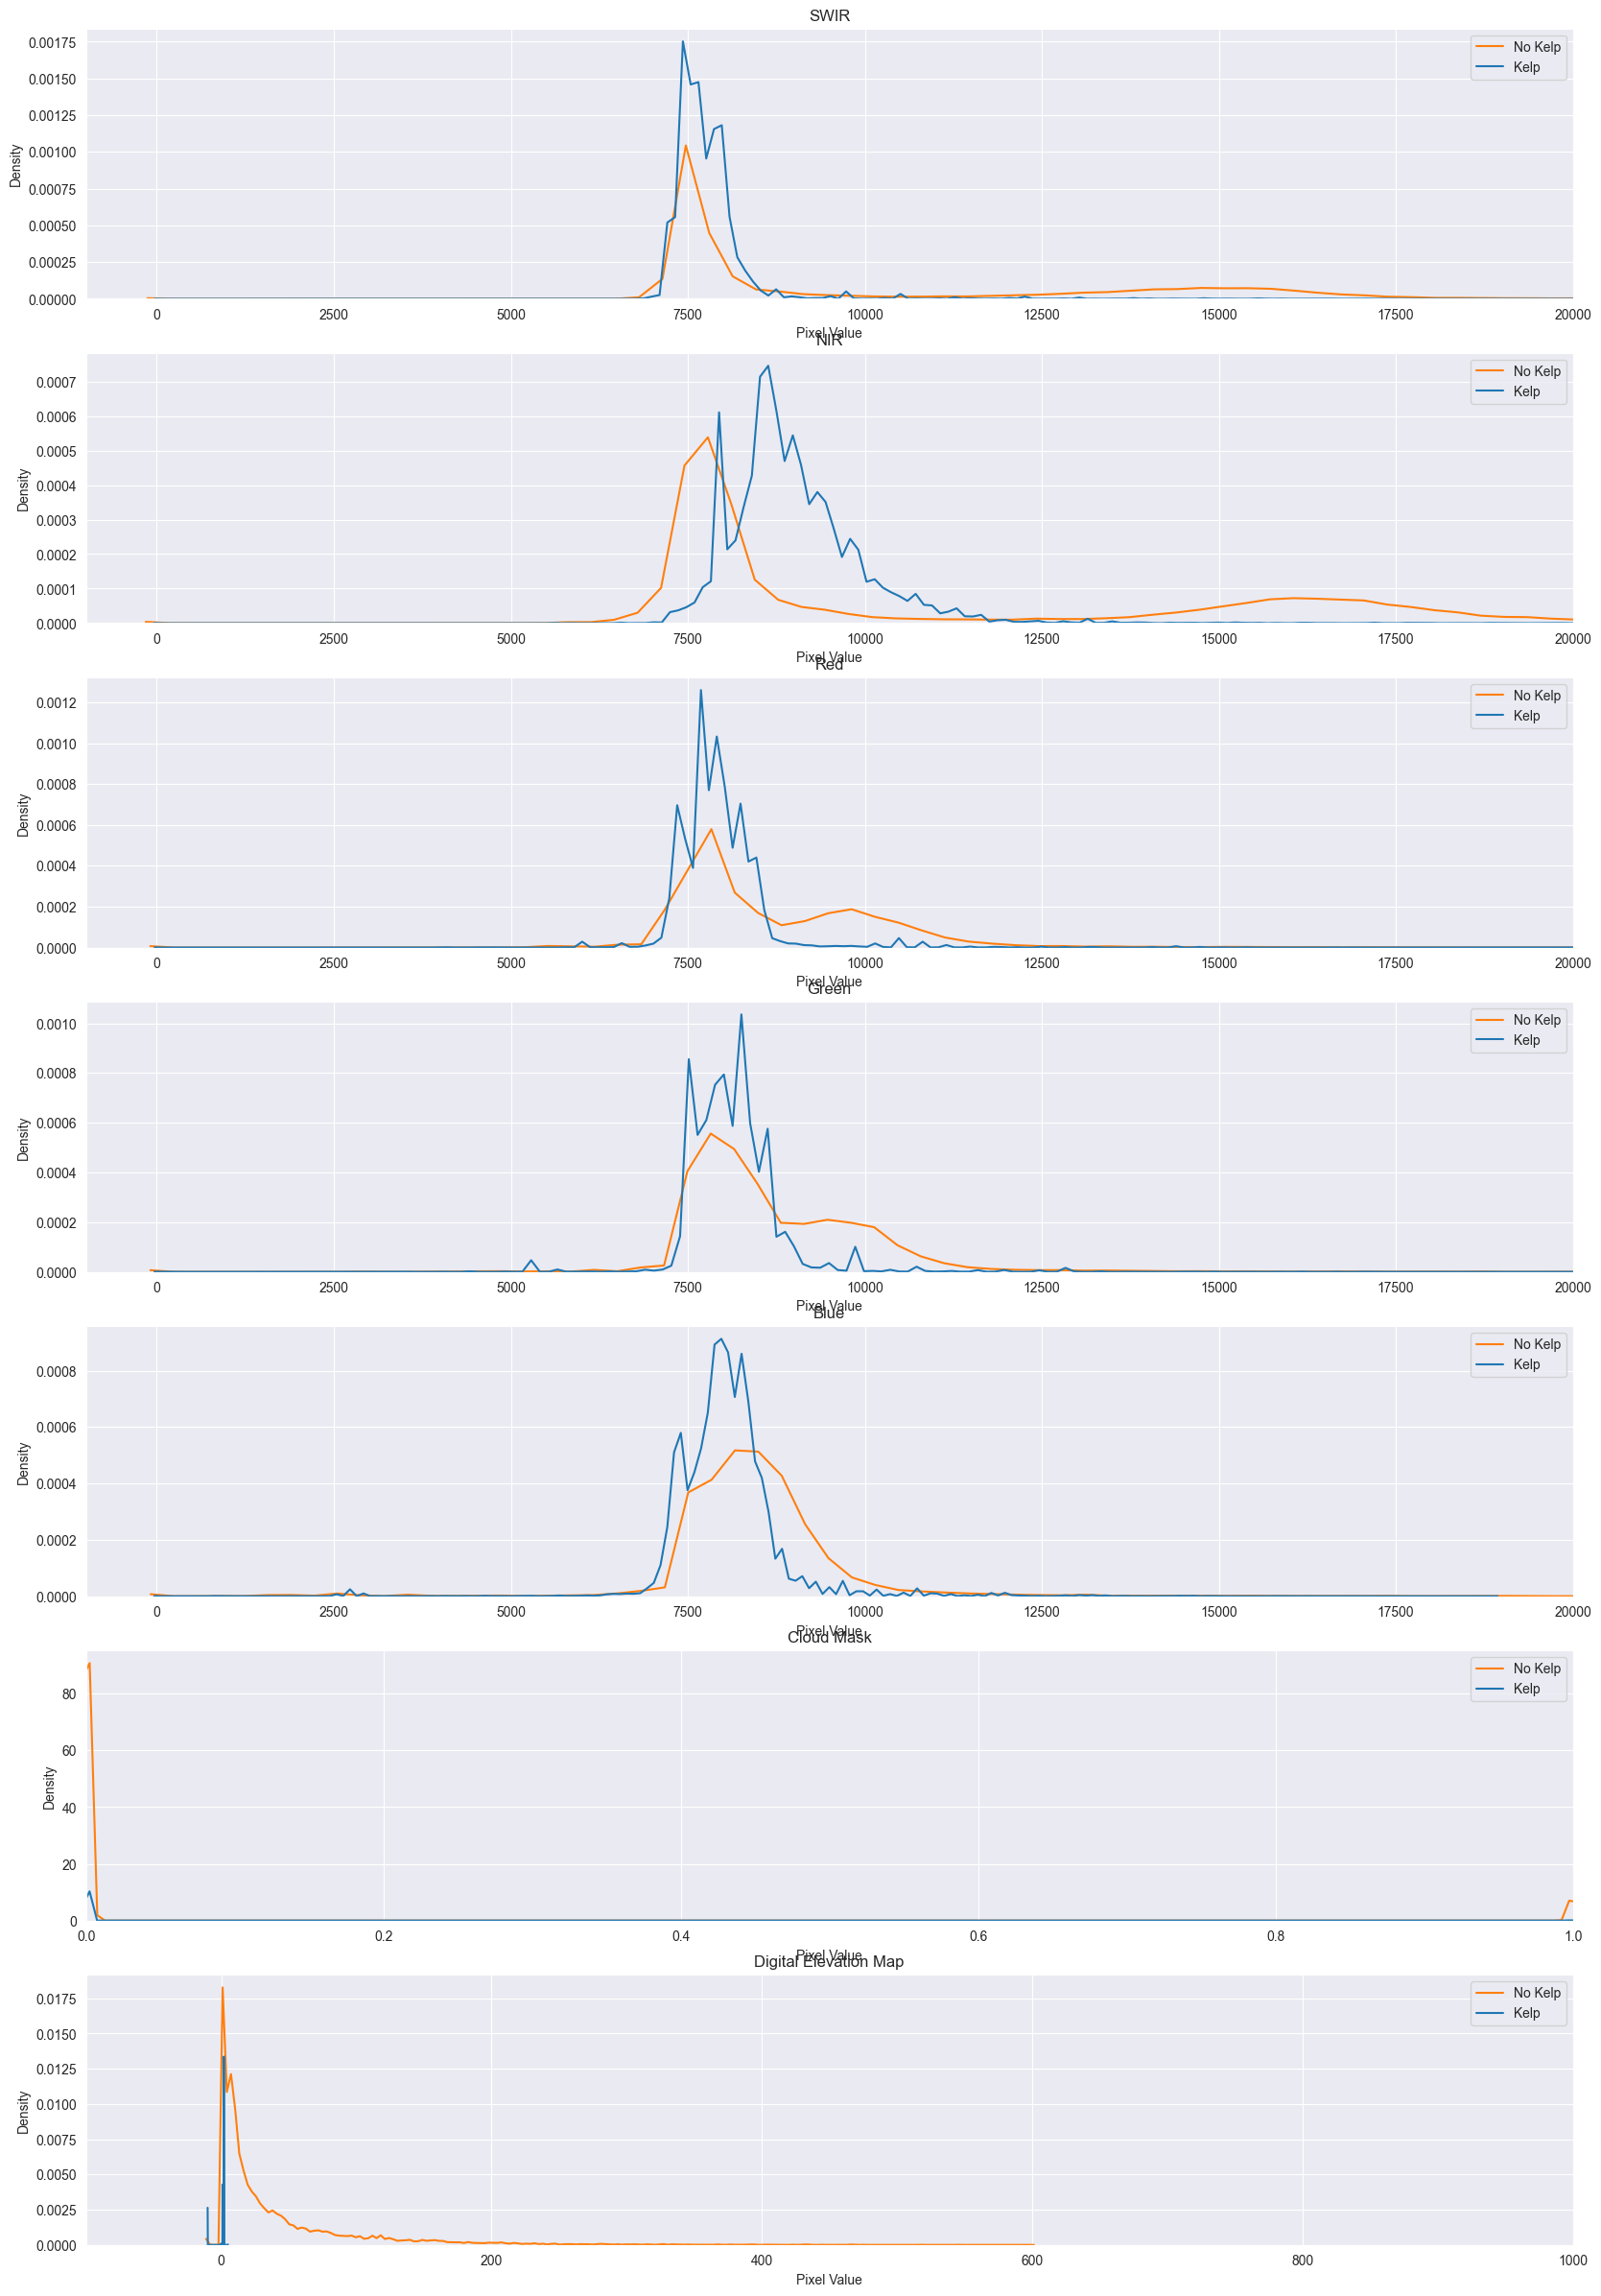

In [33]:
import seaborn as sns

fig, axes = plt.subplots(7, 1, figsize=(20, 30))

#Get indices where 


for band in range(7):
    #kelp = np.random.choice(bands_kelp_subsample[band], int(0.7307 / 100 * 100000))
    kelp = bands_kelp_subsample[band]
    # If kelp is nan (-32768) set to -10
    kelp[kelp == -32768] = -10

    no_kelp = bands_no_kelp_subsample[band]

    # If no kelp is nan (-32768) set to -10
    no_kelp[no_kelp == -32768] = -10

    #Plot the kdeplot
    sns.kdeplot(data=[kelp, no_kelp], ax=axes[band], bw_adjust=.1, common_norm=False)
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["No Kelp", "Kelp"])

    #Set range of plots from 0-20000
    axes[band].set_xlim(-1000, 20000)

    if band == 5:
        axes[band].set_xlim(0, 1)

    if band == 6:
        axes[band].set_xlim(-100, 1000)

plt.savefig('../plots/images/train/kdeplot_all_bands_kelp.png')

Ok now lets filter on elevation being smaller then 2 meters. We should see more kelp there.

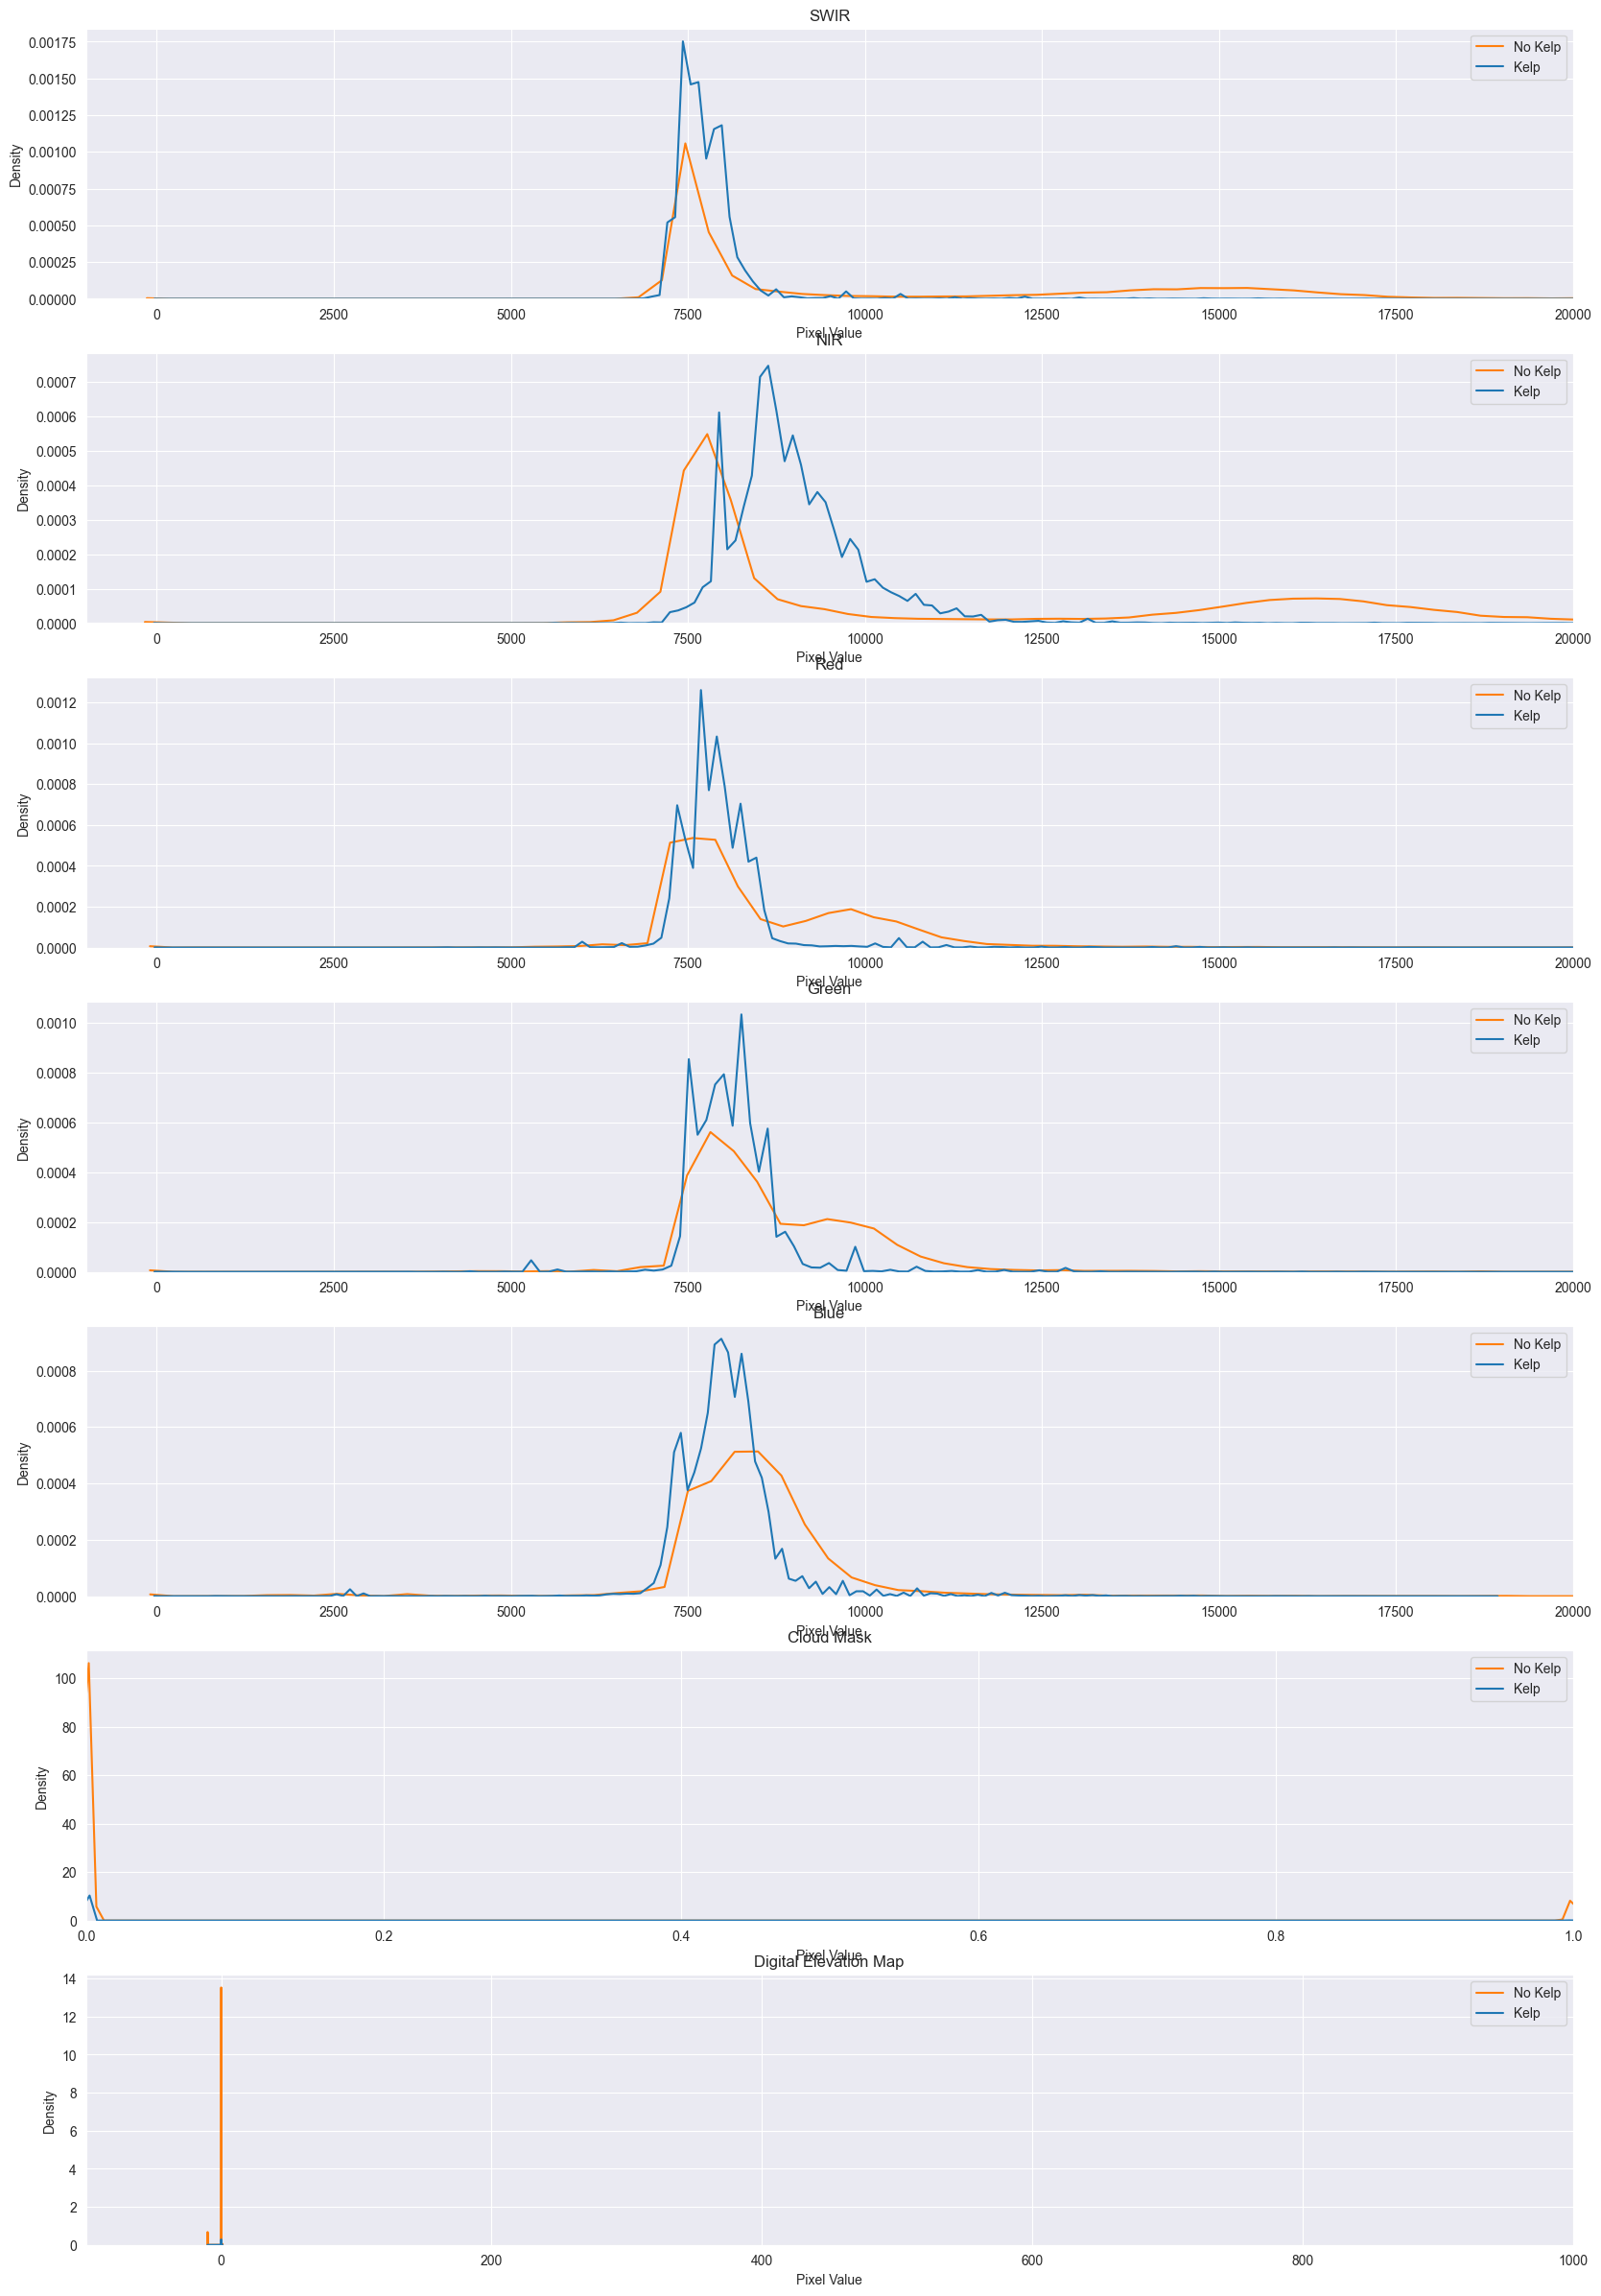

In [40]:
fig, axes = plt.subplots(7, 1, figsize=(20, 30))

# Get the indices where band 6 is smaller then 2 meters
y_kelp_smaller = np.where(bands_kelp_subsample[6] < 2)[0]

y_no_kelp_smaller = np.where(bands_no_kelp_subsample[6] < 2)[0]

for band in range(7):
    #kelp = np.random.choice(bands_kelp_subsample[band], int(0.7307 / 100 * 100000))
    kelp = bands_kelp_subsample[band][y_kelp_smaller]
    # If kelp is nan (-32768) set to -10
    kelp[kelp == -32768] = -10

    no_kelp = bands_no_kelp_subsample[band][y_no_kelp_smaller]

    # If no kelp is nan (-32768) set to -10
    no_kelp[no_kelp == -32768] = -10

    #Plot the kdeplot
    sns.kdeplot(data=[kelp, no_kelp], ax=axes[band], bw_adjust=.1, common_norm=False)
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["No Kelp", "Kelp"])

    #Set range of plots from 0-20000
    axes[band].set_xlim(-1000, 20000)

    if band == 5:
        axes[band].set_xlim(0, 1)

    if band == 6:
        axes[band].set_xlim(-100, 1000)

plt.savefig('../plots/images/train/kdeplot_all_bands_kelp_elevation_smaller_2.png')




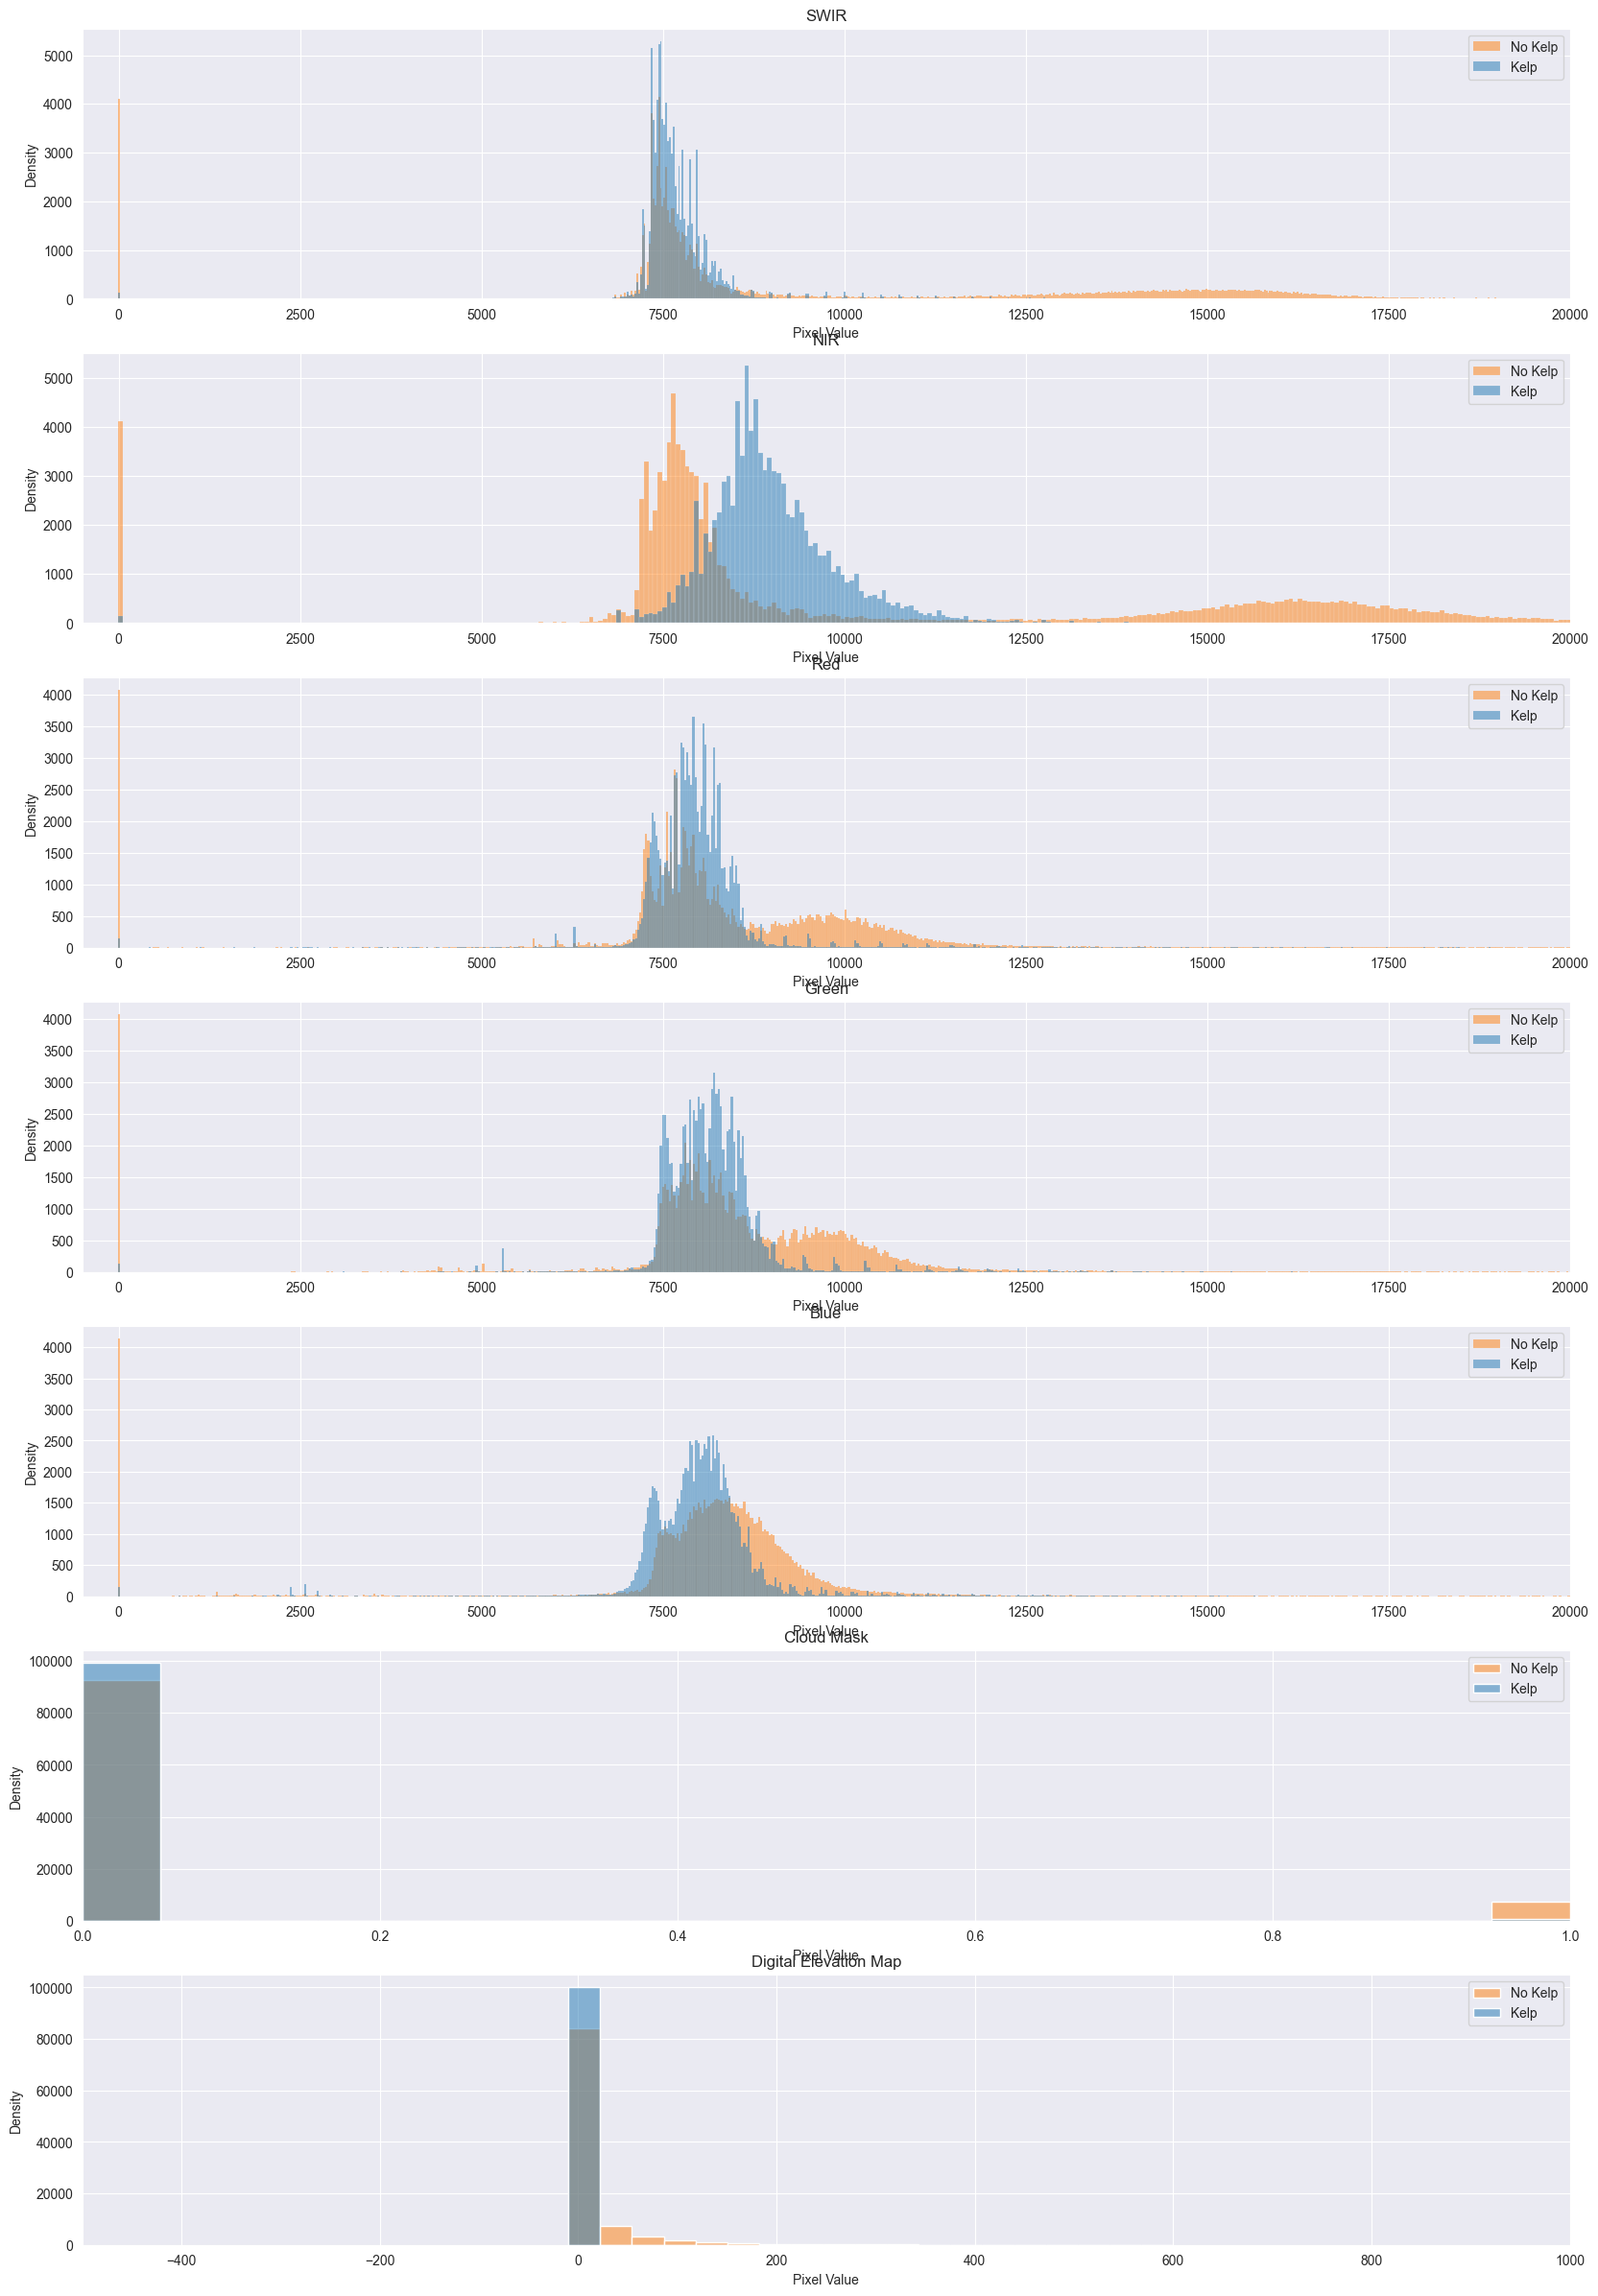

In [45]:
fig, axes = plt.subplots(7, 1, figsize=(20, 30))

#Get indices where 

for band in range(7):
    # Subsample 20000 values from kelp
    kelp = bands_kelp_subsample[band]

    # If kelp is nan (-32768) set to -10
    kelp[kelp == -32768] = -10

    # Subsample 20000 values from no kelp
    no_kelp = bands_no_kelp_subsample[band]
    # If no kelp is nan (-32768) set to -10
    no_kelp[no_kelp == -32768] = -10
    #Plot the kdeplot
    sns.histplot(data=[kelp, no_kelp], ax=axes[band])
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["No Kelp", "Kelp"])

    #Set range of plots from 0-20000
    axes[band].set_xlim(-500, 20000)

    if band == 5:
        axes[band].set_xlim(0, 1)

    if band == 6:
        axes[band].set_xlim(-500, 1000)

plt.savefig('../plots/images/train/histplot_all_bands_kelp.png')

### Leakage check: Now we want to check for leakage in train and test.


In [8]:
import cv2
from skimage import metrics

# Create SIFT detector
sift = cv2.SIFT_create(    contrastThreshold=0.01,
    edgeThreshold=5.0,
    nOctaveLayers=4,
    sigma=1.6)


while True:
    #Random train image
    train_int = np.random.randint(0, X_train.shape[0])
    test_int = np.random.randint(0, X_test.shape[0])

    train_name = file_list[0][train_int]
    test_name = file_list[2][test_int]

    s_train = X_train[train_int, :, :, :]
    s_test = X_test[test_int, :, :, :]
    s_train = normalize_image(s_train)
    s_test = normalize_image(s_test)
    elevation_band = 6

    normalized_train = (s_test * 255).astype(np.uint8)
    normalized_test = (s_train * 255).astype(np.uint8)

    # Extract a single channel (assuming the first channel)
    
    #Calculate SSIM for each band and calculate avg
    total_score = 0
    for band in range(6,7):
        ssim_score = metrics.structural_similarity(normalized_train[band, :, :], normalized_test[band, :, :])
        total_score += ssim_score
    avg_score = total_score / 1
    
    if avg_score > 0.98:
        print(f"SSIM score: {avg_score:.4f}, Train name: {train_name, train_int}, Test name: {test_name,test_int}")
        
        


    # # Detect keypoints and compute descriptors
    # keypoints1, descriptors1 = sift.detectAndCompute(elevation_train, None)
    # keypoints2, descriptors2 = sift.detectAndCompute(elevation_test, None)
    # 
    # # Calculate SSIM score
    # ssim_score = metrics.structural_similarity(elevation_train, elevation_test)
    # 
    # if ssim_score > 0.9:
    #     print(f"SSIM score: {ssim_score:.2f}, Train name: {train_name, train_int}, Test name: {test_name,test_int}")
    # 
    # if len(keypoints1) == 0:
    #     continue
    # if len(keypoints2) == 0:
    #     continue
    # # Create a Brute Force Matcher
    # bf = cv2.BFMatcher()
    # 
    # # Match descriptors
    # matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    # 
    # # Apply ratio test
    # good_matches = []
    # 
    # try: 
    #     for m, n in matches:
    #         if m.distance < 0.75 * n.distance:
    #             good_matches.append(m)
    # except Exception:
    #     continue
    # 
    # 
    # # Calculate a similarity score
    # similarity_score = len(good_matches) / min(len(keypoints1), len(keypoints2))
    # 
    # # Print the similarity score with the train name and int
    # if similarity_score > 4:
    #     print(f"Similarity score: {similarity_score:.2f}, Train name: {train_name, train_int}, Test name: {test_name,test_int}")
    #     
        
    continue 

SSIM score: 0.9952, Train name: ('HJ140989_satellite.tif', 1598), Test name: ('HB297209_satellite.tif', 404)
SSIM score: 0.9849, Train name: ('XS334865_satellite.tif', 5116), Test name: ('ZP624344_satellite.tif', 1401)
SSIM score: 0.9859, Train name: ('WT885829_satellite.tif', 4922), Test name: ('WV532232_satellite.tif', 1238)
SSIM score: 0.9871, Train name: ('IZ942570_satellite.tif', 1947), Test name: ('EL271241_satellite.tif', 245)
SSIM score: 0.9893, Train name: ('LE638637_satellite.tif', 2399), Test name: ('RH287214_satellite.tif', 930)
SSIM score: 0.9996, Train name: ('AV549875_satellite.tif', 163), Test name: ('NV456342_satellite.tif', 753)
SSIM score: 0.9857, Train name: ('ME980945_satellite.tif', 2621), Test name: ('AR682032_satellite.tif', 41)
SSIM score: 0.9869, Train name: ('HN769989_satellite.tif', 1641), Test name: ('ZV849019_satellite.tif', 1418)
SSIM score: 0.9848, Train name: ('FO762021_satellite.tif', 1237), Test name: ('HH555671_satellite.tif', 414)
SSIM score: 0.9915

KeyboardInterrupt: 

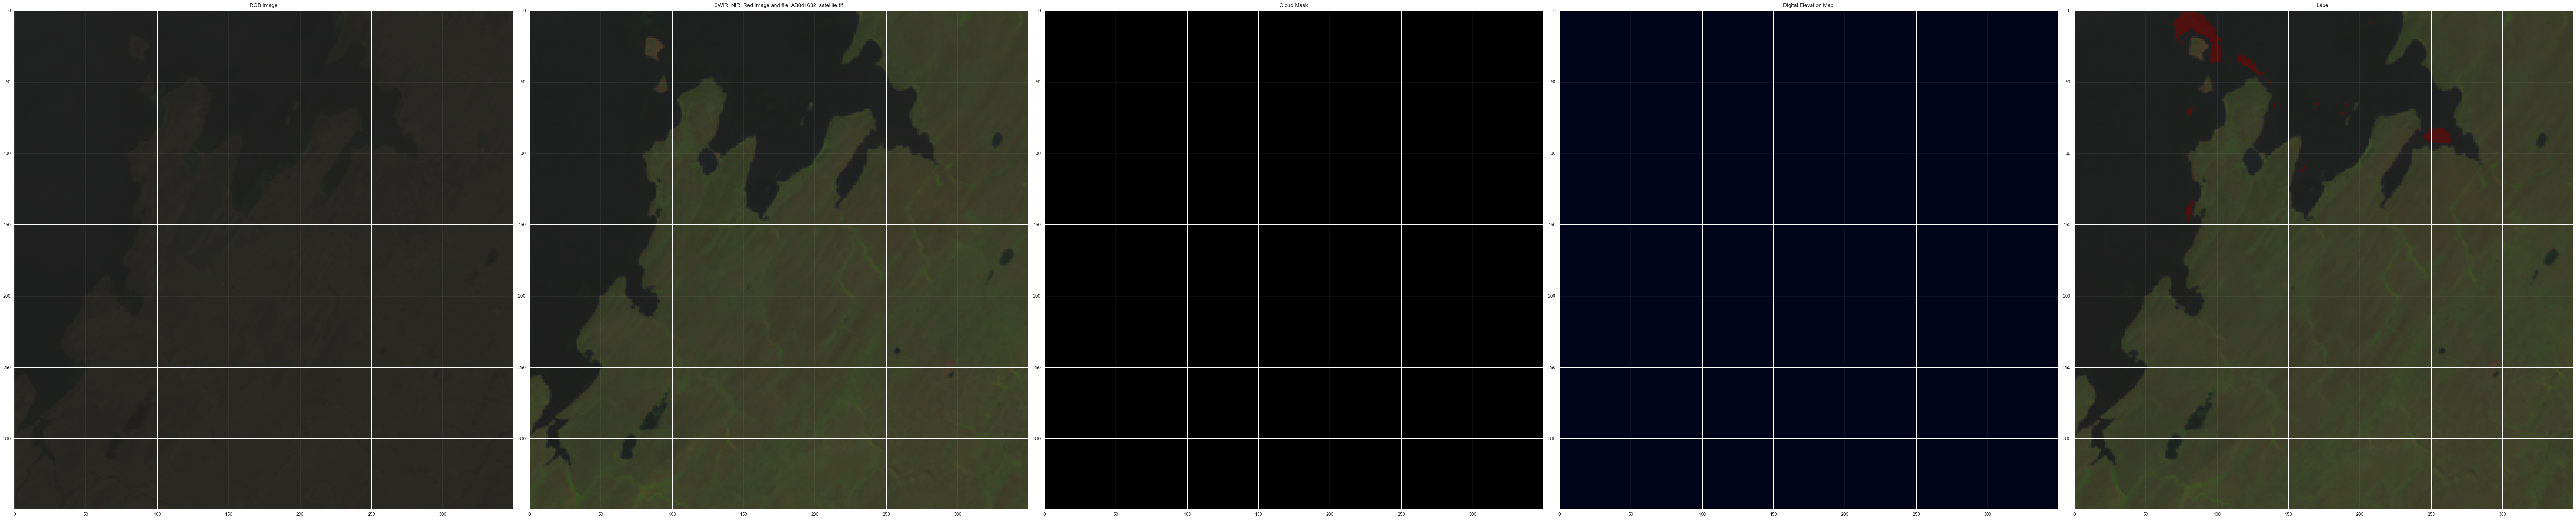

In [193]:
visualize_images([5434], is_train=True)

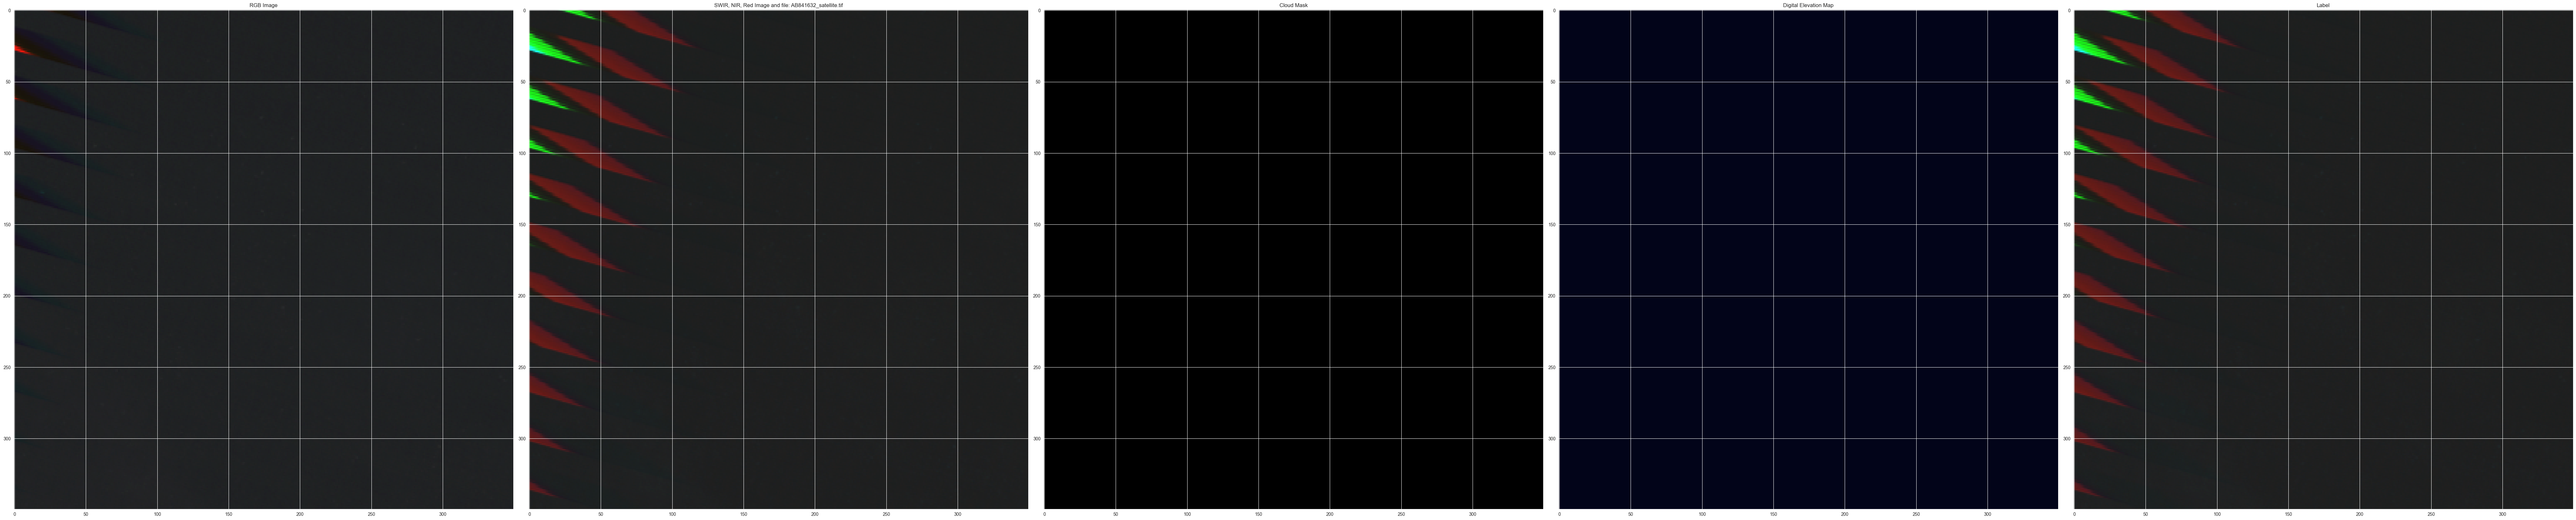

In [194]:
visualize_images([287], is_train=False)

In [195]:
!pip install git+https://github.com/openai/CLIP.git
!pip install open_clip_torch
!pip install sentence_transformers

  Cloning https://github.com/openai/CLIP.git to c:\users\hjdeh\appdata\local\temp\pip-req-build-0cidvg3q
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/53.4 kB ? eta -:--:--
   ---------------------------------------- 53.4/53.4 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.6 kB ? eta -:--:--
   --------------------------------------- 269.6/269.6 kB 16.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\hjdeh\AppData\Local\Temp\pip-req-build-0cidvg3q'


     ---------------------------------------- 0.0/977.5 kB ? eta -:--:--
     ------------------------------------- 977.5/977.5 kB 60.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 99.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/311.7 kB ? eta -:--:--
   ---------------------------------------- 311.7/311.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   --------------------------------------- 413.4/413.4 kB 25.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 71.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/169.0 kB ? eta -:--:--
   ----------------------------------

In [7]:
import torch
import open_clip
import cv2
from sentence_transformers import util
from PIL import Image
# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1).cpu().detach()
    return img1

def generateScore(encoded1, encoded2):
    cos_scores = util.pytorch_cos_sim(encoded1, encoded2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score


#similarity Score: 76.77

In [39]:
model = None

In [8]:
from tqdm import tqdm
import gc
#Encode all training images
rgb_train_encoded = []
ir_train_encoded = []
for train_int in tqdm(range(len(X_train))):
    train_name = file_list[0][train_int]
    s_train = X_train[train_int, :, :, :]
    s_train = normalize_image(s_train)
    normalized_train = (s_train * 255).astype(np.uint8)
    img1 = np.transpose(normalized_train[0:3,:,:], (1,2,0))
    img2 = np.transpose(normalized_train[2:5,:,:], (1,2,0))
    img1 = imageEncoder(img1)
    img2 = imageEncoder(img2)
    ir_train_encoded.append(img1)
    rgb_train_encoded.append(img2)
    torch.cuda.empty_cache()
    gc.collect()

100%|██████████| 5635/5635 [15:56<00:00,  5.89it/s]


In [13]:
to_save = (rgb_train_encoded, ir_train_encoded)
torch.save(to_save, "../data/training/encoded_images.pt")
torch.save(to_save, "encoded_images.pt")

In [12]:
#Load test
rgb_train_encoded_test, ir_train_encoded_test = torch.load("../data/training/encoded_images.pt")

In [10]:
# Given all the rgb and ir encoded images, create a similarity matrix of train vs train using the avg generate score.
# Initialize an empty similarity matrix
size = len(rgb_train_encoded)
similarity_matrix = np.zeros((size, size))

for i, (rgb_i, ir_i) in tqdm(enumerate(zip(rgb_train_encoded, ir_train_encoded))):
    for j, (rgb_j, ir_j) in enumerate(zip(rgb_train_encoded, ir_train_encoded)):
        score1 = generateScore(rgb_i, rgb_j)
        score2 = generateScore(ir_i, ir_j)
        avg_score = (score1 + score2) / 2
        similarity_matrix[i, j] = avg_score

#Convert to dataframe with the filenames
similarity_matrix_df = pd.DataFrame(similarity_matrix, columns=file_list[0], index=file_list[0])

#Save to file in data/training and notebooks.
similarity_matrix_df.to_csv("../data/training/similarity_matrix.csv")
similarity_matrix_df.to_csv("similarity_matrix.csv")



112it [00:36,  3.09it/s]


KeyboardInterrupt: 

In [ ]:
similarity_matrix.head()

In [8]:
torch.cuda.empty_cache()
gc.collect()

1704

In [10]:
import gc


def visualize_leakage(train_int, train_name, test_int, test_name, score):
    # Create a 2x3 grid for image display
    num_rows = 2
    num_cols = 5

    X_train_normed = normalize_image(X_train[train_int, :, :, :])
    X_test_normed = normalize_image(X_test[test_int, :, :, :])

    X = (X_train_normed, X_test_normed)
    X_names = (train_name, test_name)
    train_or_test = ("Train", "Test")
    # Create a figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(60, num_rows * 15))

    # Flatten the 2D array of subplots into a 1D array
    axes = axes.flatten()
    c = 0
    cmap_mask = ListedColormap(['black', 'white'])
    # Display each image in a subplot
    for i in range(0, num_rows * num_cols, 5):
        # Display the RGB image
        show(X[c][2:5, :, :], ax=axes[i])
        axes[i].set_title(f"RGB Image of {train_or_test[c]} - {X_names[c]}")

        # Display the SWIR, NIR, Red image
        show(X[c][0:3, :, :], ax=axes[i + 1])
        axes[i + 1].set_title(f"SWIR, NIR, Red Image of {train_or_test[c]} - {X_names[c]}")

        # Display the Cloud mask band (5)
        axes[i + 2].imshow(X[c][5, :, :], cmap=cmap_mask)
        axes[i + 2].set_title(f"Cloud Mask of {train_or_test[c]} - {X_names[c]}")

        # Display the Digital Elevation Map band (6)
        show(X[c][6, :, :], ax=axes[i + 3])
        axes[i + 3].set_title(f"Digital Elevation Map of {train_or_test[c]} - {X_names[c]}")

        # Display the label on the RBG
        show(X[c][0:3, :, :], ax=axes[i + 4])
        if c == 0:
            axes[i + 4].imshow(y_train[train_int][0], cmap='jet', alpha=0.5 * (y_train[train_int][0] > 0))
        axes[i + 4].set_title(f"Label of {train_or_test[c]} - {X_names[c]}")
        # Display the SWIR, NIR, Red image with the label
        c += 1
    # Remove gridlines
    for ax in axes:
        ax.grid(False)
        
    # Adjust layout for better spacing
    plt.tight_layout()
    fig.suptitle(f"Similarity score: {score:.2f}, Train name: {train_name, train_int}, Test name: {test_name,test_int}")
    plt.savefig(f'../plots/images/leakage/{avg_score:.2f}-{str(train_name)}-{str(test_name)}.png')
    fig.clf()
    plt.close('all')
    
    gc.collect()



In [7]:
import csv
from tqdm import tqdm

#Create a file with all the leakage
file_path = "../plots/images/leakage/leakage.txt"
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Train name", "Train int", "Test name", "Test int", "Similarity score"])

for train_int in range(len(X_train)):
    print(f"{train_int} / {len(X_train)}")
    for test_int in tqdm(range(len(X_test))):
        train_name = file_list[0][train_int]
        test_name = file_list[2][test_int]
    
        s_train = X_train[train_int, :, :, :]
        s_test = X_test[test_int, :, :, :]
        s_train = normalize_image(s_train)
        s_test = normalize_image(s_test)
    
        normalized_train = (s_test * 255).astype(np.uint8)
        normalized_test = (s_train * 255).astype(np.uint8)
        
        img1 = np.transpose(normalized_train[0:3,:,:], (1,2,0))
        img2 = np.transpose(normalized_test[0:3,:,:], (1,2,0))
        
        img3 = np.transpose(normalized_train[2:5,:,:], (1,2,0))
        img4 = np.transpose(normalized_test[2:5,:,:], (1,2,0))
        
        score1 = generateScore(img1, img2)
        score2 = generateScore(img3, img4)
        avg_score = (score1 + score2) / 2
        
        if avg_score > 90:
            with open(file_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([train_name, train_int, test_name, test_int, avg_score])
            #print(f"Similarity score: {avg_score:.4f}, Train name: {train_name, train_int}, Test name: {test_name,test_int}")
            
        if avg_score > 95:
            visualize_leakage(train_int, train_name, test_int, test_name, avg_score)

0 / 5635


  0%|          | 0/1426 [00:00<?, ?it/s]


RuntimeError: linalg.vector_norm: Expected a floating point or complex tensor as input. Got Byte

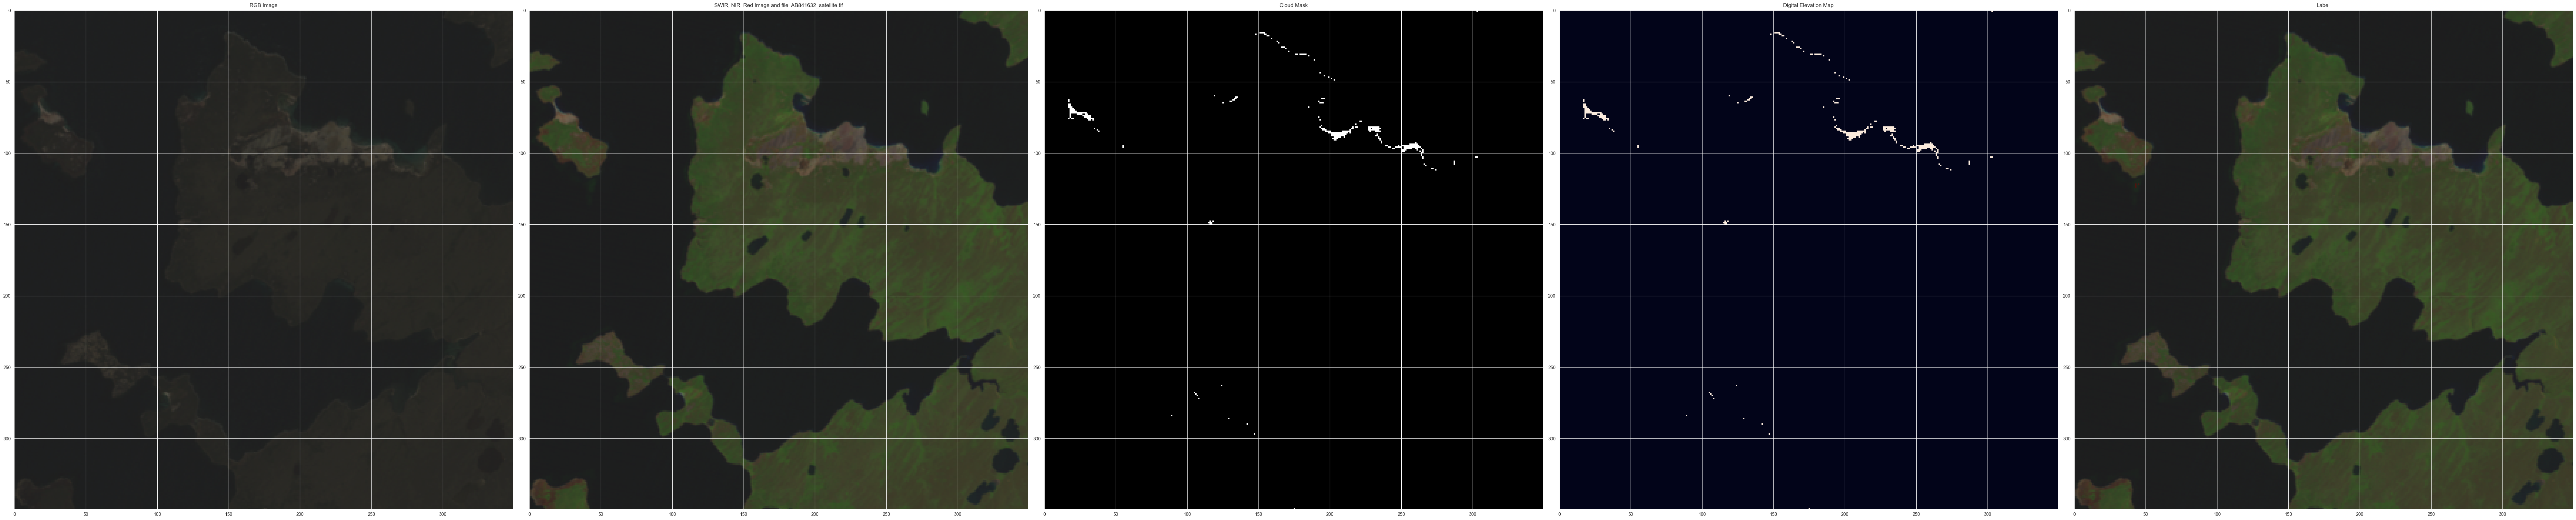

In [220]:
visualize_images([5363], is_train=True)

In [ ]:
# Some leaky images:
#5363,train,1080,test